# Small model for CIFAR10

Architecture based on general scheme of transformers.

Ideas from:
- MetaFormer, [arXiv:2111.11418 [cs.CV]](https://arxiv.org/abs/2111.11418)
- ConvMixer, [arXiv:2201.09792 [cs.CV]](https://arxiv.org/abs/2201.09792)
- ConvNeXt, [arXiv:2201.03545 [cs.CV]](https://arxiv.org/abs/2201.03545)

## Configuration

Imports

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [2]:
DATA_DIR='./data'

IMAGE_SIZE = 32

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 512
EPOCHS = 200

LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-1

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [4]:
train_transform = transforms.Compose([
    transforms.TrivialAugmentWide(interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.RandomErasing(p=0.1)
])

In [5]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
val_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False,
                                         num_workers=NUM_WORKERS, pin_memory=True)

## Model

In [7]:
class Residual(nn.Module):
    def __init__(self, residual, shortcut=None):
        super().__init__()
        self.residual = residual
        self.shortcut = shortcut if shortcut is not None else nn.Identity()
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return self.shortcut(x) + self.gamma * self.residual(x)

Block

In [8]:
class SpatialMixer(nn.Sequential):
    def __init__(self, channels, kernel_size, stride=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size, padding=padding, stride=stride, groups=channels)
        )

In [9]:
class ChannelMixer(nn.Sequential):
    def __init__(self, in_channels, out_channels, mult=4):
        mid_channels = in_channels * mult
        super().__init__(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, mid_channels, 1),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, 1)
        )

In [10]:
class Block(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super().__init__(
            Residual(SpatialMixer(in_channels, kernel_size, stride),
                     shortcut = nn.AvgPool2d(stride) if stride > 1 else None),
            Residual(ChannelMixer(in_channels, out_channels),
                     shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else None)
        )

Stage

In [11]:
class Stage(nn.Sequential):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride=1):
        super().__init__(
            Block(in_channels, out_channels, kernel_size, stride),
            *[Block(out_channels, out_channels, kernel_size) for _ in range(num_blocks - 1)]
        )

In [12]:
class StageStack(nn.Sequential):
    def __init__(self, in_channels, channels_list, num_blocks_list, strides, kernel_size):
        layers = []
        for num, out_channels, stride in zip(num_blocks_list, channels_list, strides):
            layers.append(Stage(in_channels, out_channels, num, kernel_size, stride))
            in_channels = out_channels
        
        super().__init__(*layers)

Main model

In [13]:
def Stem(in_channels, out_channels, kernel_size=3, stride=1):
    padding = (kernel_size - 1) // 2
    return nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride)

In [14]:
class Head(nn.Sequential):
    def __init__(self, channels, classes, p_drop=0.):
        super().__init__(
            nn.BatchNorm2d(channels),
            nn.GELU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(channels, classes)
        )

In [15]:
class Net(nn.Sequential):
    def __init__(self, classes, num_blocks_list, channels_list, strides, kernel_size, in_channels=3, head_p_drop=0.):
        super().__init__(
            Stem(in_channels, channels_list[0], stride=strides[0]),
            StageStack(channels_list[0], channels_list, num_blocks_list, strides[1:], kernel_size),
            Head(channels_list[-1], classes, head_p_drop)
        )

In [16]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Conv1d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [17]:
model = Net(NUM_CLASSES,
            num_blocks_list = [4, 4, 2, 2],
            channels_list = [32, 64, 128, 256],
            strides = [1, 1, 2, 2, 2],
            kernel_size = 5,
            head_p_drop = 0.3)

In [18]:
model.apply(init_linear);

In [19]:
model.to(DEVICE);

In [20]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 1,124,642


## Training

### Trainer setup

In [21]:
loss = nn.CrossEntropyLoss(label_smoothing=0.1)

In [22]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [23]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

Trainer

In [24]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [25]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [26]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

Evaluator

In [27]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [28]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [29]:
history = defaultdict(list)

In [30]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Start training

In [34]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/200 - train: loss 2.228; val: loss 1.970 accuracy 0.302
2/200 - train: loss 2.049; val: loss 1.775 accuracy 0.411
3/200 - train: loss 1.907; val: loss 1.769 accuracy 0.419
4/200 - train: loss 1.795; val: loss 1.558 accuracy 0.524
5/200 - train: loss 1.682; val: loss 1.414 accuracy 0.594
6/200 - train: loss 1.607; val: loss 1.357 accuracy 0.626
7/200 - train: loss 1.541; val: loss 1.294 accuracy 0.644
8/200 - train: loss 1.480; val: loss 1.237 accuracy 0.686
9/200 - train: loss 1.434; val: loss 1.202 accuracy 0.697
10/200 - train: loss 1.398; val: loss 1.156 accuracy 0.723
11/200 - train: loss 1.346; val: loss 1.116 accuracy 0.739
12/200 - train: loss 1.322; val: loss 1.056 accuracy 0.771
13/200 - train: loss 1.286; val: loss 1.060 accuracy 0.773
14/200 - train: loss 1.254; val: loss 1.026 accuracy 0.782
15/200 - train: loss 1.229; val: loss 0.989 accuracy 0.796
16/200 - train: loss 1.207; val: loss 0.995 accuracy 0.794
17/200 - train: loss 1.198; val: loss 0.946 accuracy 0.815
18/200

In [35]:
def history_plot_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()

In [36]:
def history_plot(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history[key]) + 1)
    ax.plot(xs, history[key], '.-')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid()
    plt.show()

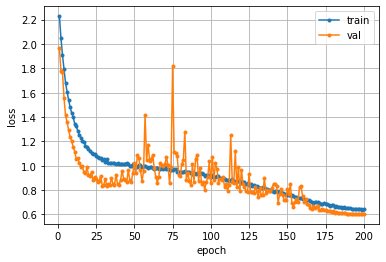

In [37]:
history_plot_train_val(history, 'loss')

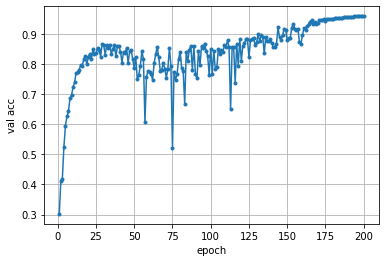

In [38]:
history_plot(history, 'val acc')